## Import liabraries

In [48]:
## Import required frameworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Import 'car_price_data.csv' data set

Data preparation

In [31]:
# Load the dataset and select relevant columns
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

df = pd.read_csv(url, usecols=['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
                               'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP'])

# Lowercase column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Fill missing values with 0
df.fillna(0, inplace=True)

In [32]:
## Make prices binary
# Convert prices of cars into a binary format

# Calculate the mean of the "price" column
mean_price = df['msrp'].mean()

# Convert values to binary distribution
df['above_average'] = df['msrp'].apply(lambda x: 1 if x >= mean_price else 0)

In [33]:
# Overview of the DataFrame "df"
print(df.head)

<bound method NDFrame.head of           make       model  year  engine_hp  engine_cylinders  \
0          BMW  1 Series M  2011      335.0               6.0   
1          BMW    1 Series  2011      300.0               6.0   
2          BMW    1 Series  2011      300.0               6.0   
3          BMW    1 Series  2011      230.0               6.0   
4          BMW    1 Series  2011      230.0               6.0   
...        ...         ...   ...        ...               ...   
11909    Acura         ZDX  2012      300.0               6.0   
11910    Acura         ZDX  2012      300.0               6.0   
11911    Acura         ZDX  2012      300.0               6.0   
11912    Acura         ZDX  2013      300.0               6.0   
11913  Lincoln      Zephyr  2006      221.0               6.0   

      transmission_type  vehicle_style  highway_mpg  city_mpg   msrp  \
0                MANUAL          Coupe           26        19  46135   
1                MANUAL    Convertible       

Make prices binary

Split the data into the train/validation/test with 60%/20%/20% distribution

In [34]:
# Split the dataset into train/validation/test (60%/20%/20%) with random_state=1
X = df.drop(columns=['msrp', 'above_average'])
y = df['above_average']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Print the shapes of the resulting sets to verify the distribution
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (7148, 9), y_train shape: (7148,)
X_val shape: (2383, 9), y_val shape: (2383,)
X_test shape: (2383, 9), y_test shape: (2383,)


## Question 1
Find feature importance using the method ROC AUC 

In [35]:
print(X_train.head)

<bound method NDFrame.head of              make       model  year  engine_hp  engine_cylinders  \
3840      Hyundai  Elantra GT  2016      173.0               4.0   
5780   Mitsubishi      i-MiEV  2017       66.0               0.0   
8637         Audi        RS 5  2014      450.0               8.0   
5620   Volkswagen         GTI  2012      200.0               4.0   
122         Mazda           2  2014      100.0               4.0   
...           ...         ...   ...        ...               ...   
7813         Audi          Q5  2016      272.0               6.0   
10955      Toyota      Tundra  2015      381.0               8.0   
905          Saab         900  1997      150.0               4.0   
5192      Pontiac          G6  2009      164.0               4.0   
235      Chrysler        300M  2003      255.0               6.0   

      transmission_type    vehicle_style  highway_mpg  city_mpg  
3840             MANUAL    4dr Hatchback           33        24  
5780       DIRECT_DRI

In [36]:
print(y_train.head)

<bound method NDFrame.head of 3840     0
5780     0
8637     1
5620     0
122      0
        ..
7813     1
10955    1
905      0
5192     0
235      0
Name: above_average, Length: 7148, dtype: int64>


In [37]:
# Dictionary to store AUC scores for each variable
auc_scores = {}

# Define a list of numerical features
numerical_variables = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

# Iterate through each numerical variable
for variable in numerical_variables:
    # Calculate the AUC score
    auc = roc_auc_score(y_train, X_train[variable])
    
    # Check if AUC is less than 0.5, and if so, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[variable])

    # Store the AUC score in the dictionary
    auc_scores[variable] = auc
    

# Find the numerical variable with the highest AUC
highest_auc_variable = max(auc_scores, key=auc_scores.get)

# Print the AUC scores and the variable with the highest AUC
for variable, auc in auc_scores.items():
    print(f"{variable}: AUC = {auc:.3f}")

print(f"The numerical variable with the highest AUC is: {highest_auc_variable}")

engine_hp: AUC = 0.916
engine_cylinders: AUC = 0.768
highway_mpg: AUC = 0.633
city_mpg: AUC = 0.672
The numerical variable with the highest AUC is: engine_hp


## Question 2
Train the logistic regression model and find the ROC AUC score 

In [38]:
# Apply one-hot encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(X_train.to_dict(orient='records'))
X_val_encoded = dv.transform(X_val.to_dict(orient='records'))
X_test_encoded = dv.transform(X_test.to_dict(orient='records'))

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Predict probabilities for the validation set
y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

# Compute the AUC score for the logistic regression model
auc_score = roc_auc_score(y_val, y_val_pred_proba)
print(f"AUC score for the Logistic Regression model: {auc_score:.3f}")

AUC score for the Logistic Regression model: 0.976


## Question 3
Precision and Recall

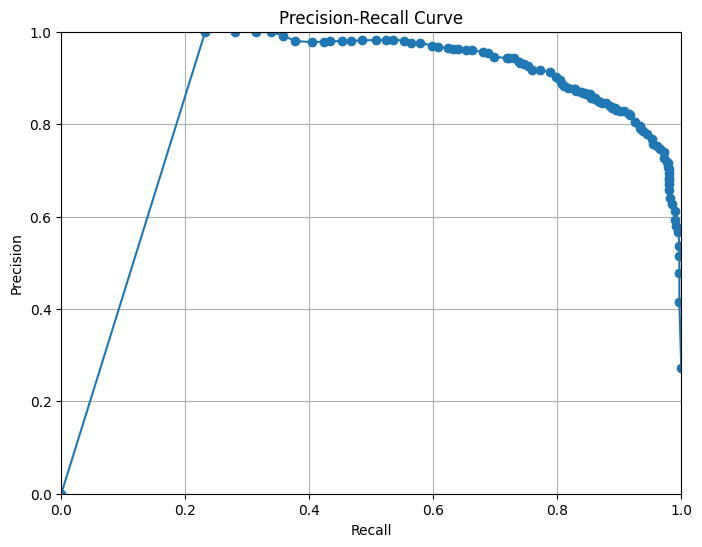

In [40]:
# Initialize lists to store precision and recall values
precision_values = []
recall_values = []

# Define a range of thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Iterate through each threshold
for threshold in thresholds:
    # Predict binary labels based on the threshold
    y_val_pred_binary = (y_val_pred_proba >= threshold).astype(int)
    
    # Compute precision and recall
    true_positive = ((y_val == 1) & (y_val_pred_binary == 1)).sum()
    false_positive = ((y_val == 0) & (y_val_pred_binary == 1)).sum()
    false_negative = ((y_val == 1) & (y_val_pred_binary == 0)).sum()
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    
    # Append precision and recall values to the lists
    precision_values.append(precision)
    recall_values.append(recall)

# Create a precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, marker='o', linestyle='-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


## Question 4
F1 Score

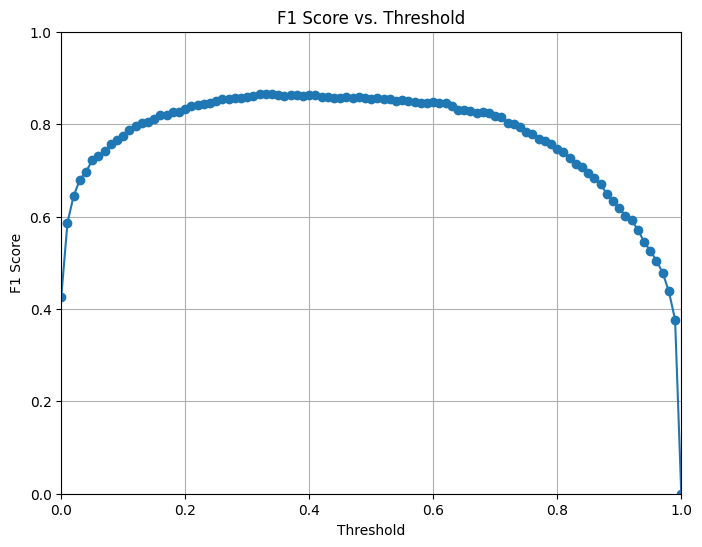

In [41]:
precision_values
recall_values

# Define a range of thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Initialize a list to store F1 scores
f1_scores = []

# Calculate F1 scores for each precision and recall pair
for precision, recall in zip(precision_values, recall_values):
    if precision + recall == 0:
        f1_scores.append(0)
    else:
        f1_scores.append(2 * (precision * recall) / (precision + recall))

# Create a plot of F1 scores
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

## Question 5
5-Fold CV

In [46]:
# Initialize K-Fold cross-validation with 5 splits, shuffling, and random state
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize an empty list to store AUC scores for each fold
auc_scores = []

# Define the logistic regression model with specified parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# Iterate over different folds of X_train
for train_idx, val_idx in kf.split(X_train_encoded):
    X_train_fold, X_val_fold = X_train_encoded[train_idx], X_train_encoded[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)
    
    # Predict probabilities for the validation fold
    y_val_fold_pred_proba = model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate AUC score for the validation fold
    auc = roc_auc_score(y_val_fold, y_val_fold_pred_proba)
    
    # Append the AUC score to the list
    auc_scores.append(auc)

# Calculate the standard deviation of AUC scores across different folds
std_deviation = np.std(auc_scores)

# Print the standard deviation of AUC scores
print(f"Standard Deviation of AUC Scores: {std_deviation:.4f}")


Standard Deviation of AUC Scores: 0.0048


## Question 6
Hyperparemeter Tuning

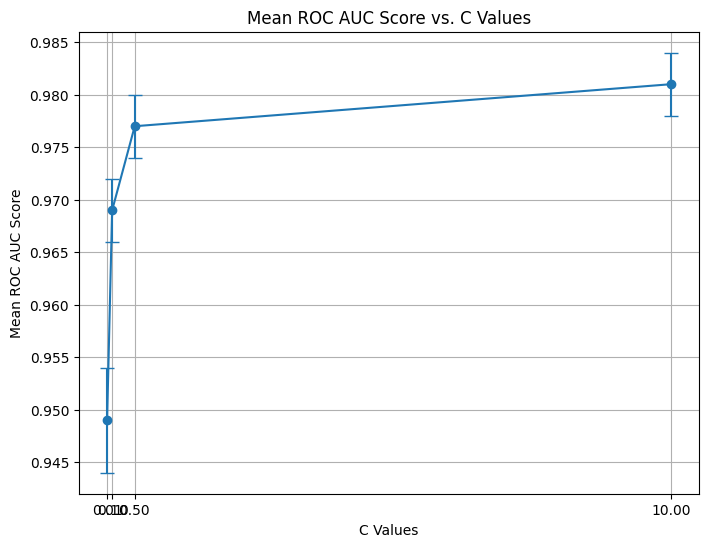

In [49]:
# Define a list of C values to iterate over
C_values = [0.01, 0.1, 0.5, 10]

# Initialize K-Fold cross-validation with 5 splits, shuffling, and random state
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize empty lists to store mean and std scores
mean_scores = []
std_scores = []

# Iterate over different C values
for C in C_values:
    # Define the logistic regression model with the current C value
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    
    # Perform cross-validation and compute AUC scores
    scores = cross_val_score(model, X_train_encoded, y_train, cv=kf, scoring='roc_auc')
    
    # Compute the mean and standard deviation of AUC scores
    mean_score = round(np.mean(scores), 3)
    std_score = round(np.std(scores), 3)
    
    # Append the mean and std scores to the respective lists
    mean_scores.append(mean_score)
    std_scores.append(std_score)

# Plot the mean scores for different C values
plt.figure(figsize=(8, 6))
plt.errorbar(C_values, mean_scores, yerr=std_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('C Values')
plt.ylabel('Mean ROC AUC Score')
plt.title('Mean ROC AUC Score vs. C Values')
plt.grid(True)
plt.xticks(C_values)
plt.show()
